## ISMIR 2015 -- MSAF Experiments ##

The idea is to run various experiments to illustrate the impact that hyper parameters have in different levels of implementation of a Music Structure Analysis system.

The following domains will be explored:
* features
* algorithms
* evaluations
* datasets

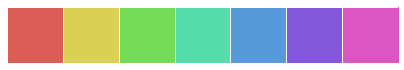

In [257]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
from scipy.stats import friedmanchisquare

from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm

import msaf

# Plotting settings
%matplotlib inline
sns.set_style("dark")
sns.set_style("darkgrid", {'legend.frameon': True})

# Colors
colors_bounds = sns.color_palette("hls", 7)
colors_labels = sns.color_palette("hls", 5)
sns.palplot(sns.color_palette("hls", 7))

n_jobs = 1
ds_base = "/home/uri/datasets/"
# ds_base = "/Users/uriadmin/"
colors = ['b', 'g', 'r', 'm', 'k', 'c', 'y']
markers = ['D', '^', '*', 'd', 'o', '.', '_']
markers_labels = ['D', '^', '*', 'd', '.']
colors_dict = {
    "r": sns_colors[0],
    "y": sns_colors[1],
    "g": sns_colors[2],
    "c": sns_colors[3],
    "b": sns_colors[4],
    "m": sns_colors[5],
    "p": sns_colors[6]}

## Features ##

Use the Checkerboard Kernel method (Foote) in the BeatlesTUT dataset using different analisys windows when computing the features.
More specifically, we fix the sampling rate (11025Hz) and explore the following params:

* Analysis window sizes: [2048, 4096] (in samples)
* Amount of overlap [50%, 75%, 87.5%]

Additionally, we show that beat-synchronous features produce significantly different results using a window of 4096 samples with 87.5% overlap.

In [80]:
framesync = True
anal_data_keys = ["frame2048_hop256", "frame2048_hop512", "frame2048_hop1024",
                  "frame4096_hop512", "frame4096_hop1024", "frame4096_hop2048"]
results = {}
for anal_data_key in anal_data_keys:
    results[anal_data_key] = pd.read_csv("../data/results_" + anal_data_key + ".csv")

In [78]:
metrics = ["HitRate_3F", "HitRate_3P", "HitRate_3R"]
# metrics = ["HitRate_t3F", "HitRate_t3P", "HitRate_t3R"]
# metrics = ["HitRate_t0.5F", "HitRate_t0.5P", "HitRate_t0.5R"]

In [79]:
print scipy.stats.ttest_rel(results["frame4096_hop2048"][metrics].values,
                            results["frame2048_hop256"][metrics].values)

(array([ 4.46395307,  8.73830081, -2.28262264]), array([  1.44676017e-05,   1.99345977e-15,   2.36698026e-02]))


In [85]:
# Multi-comparison Holm–Bonferroni, step-down method
def add_data(data, results, key, metrics):
    for scores in results[key][metrics].values:
        data.append((key, scores[0]))
        data.append((key, scores[1]))
        data.append((key, scores[2]))

data = []
for anal_data_key in anal_data_keys:
    add_data(data, results, anal_data_key, metrics)
data = np.rec.array(data, dtype=[('Params', '|S24'),('Score', '>f4')])
mod = MultiComparison(data["Score"], data["Params"])

# step-down method using Bonferroni adjustments
# see: http://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method
print mod.allpairtest(scipy.stats.ttest_rel, method='holm')[0]

Test Multiple Comparison ttest_rel 
FWER=0.05 method=holm
alphacSidak=0.00, alphacBonf=0.003
      group1            group2        stat   pval  pval_corr reject
-------------------------------------------------------------------
frame2048_hop1024  frame2048_hop256  5.4538  0.0      0.0     True 
frame2048_hop1024  frame2048_hop512  3.2704 0.0011   0.0114   True 
frame2048_hop1024 frame4096_hop1024   nan    nan      nan    False 
frame2048_hop1024 frame4096_hop2048 -2.4104 0.0163   0.0651  False 
frame2048_hop1024  frame4096_hop512  3.2704 0.0011   0.0114   True 
 frame2048_hop256  frame2048_hop512 -2.8536 0.0045   0.027    True 
 frame2048_hop256 frame4096_hop1024 -5.4538  0.0      0.0     True 
 frame2048_hop256 frame4096_hop2048 -6.2674  0.0      0.0     True 
 frame2048_hop256  frame4096_hop512 -2.8536 0.0045   0.027    True 
 frame2048_hop512 frame4096_hop1024 -3.2704 0.0011   0.0114   True 
 frame2048_hop512 frame4096_hop2048 -5.0085  0.0      0.0     True 
 frame2048_hop512  fram

In [ ]:
# print pairwise_tukeyhsd(data['Score'], data['Params'])
# print mod.tukeyhsd()
# print mod.allpairtest(scipy.stats.ttest_ind, method='b')[0]

In [88]:
# Test Beat synchronous
results["frame4096_hop512_bs"] = pd.read_csv("../data/results_frame4096_hop512_bs.csv")
print scipy.stats.ttest_ind(results["frame4096_hop512_bs"][metrics].values,
                            results["frame4096_hop512"][metrics].values)

(array([ 3.67342772,  6.35678455,  0.09211639]), array([  2.77195189e-04,   6.50615306e-10,   9.26658880e-01]))


## Features (pt 2)

Analyze the impact of the following parameters of these two features:

* Chroma:
    * Number of Octaves: $n\_octaves = [3, ..., 7]$
    * Minimum frequency: $f\_min = [27.5 \cdot 2 ^{0/12}, 27.5 \cdot 2 ^ {1/12}, ..., 27.5 \cdot 2 ^ {12/12}]$
    
* MFCC:
    * n_coeff

Use the following algorithms to explore the impact on the results:

* **Checkerboard Kernel**: Focused on Novelty segments.
* **Convex NMF**: Focused on Homogeneous segments.
* **Structural Features**: Focused on both types of segments.



In [2]:
n_octaves = [4, 5, 6, 7]
f_mins = [27.5 * 2 ** (i / 12.) for i in xrange(0, 12, 2)]
data_path = "../data/"
algorithm_dict = {
    "cc" : "Constrained Clustering",
    "cnmf": "Convex NMF",
    "fmc2d": "2D Fourier Magnitude Coeffs",
    "foote": "Checkerboard Kernel",
    "sf": "Structural Features",
    "scluster": "Laplacian Segmentation",
    "siplca": "Shift-Invariant PLCA",
    "olda": "Ordinal LDA"
}

In [3]:
def get_score(csv_file, metric="HitRate_3F"):
    """Get average score from a certain file."""
    results = pd.read_csv(csv_file)
    return results[metric]

def get_algorithm_id(csv_file, algo_type="bounds"):
    """Returns the name of the algorithm contained in the file name."""
    base_file = os.path.basename(csv_file)
    params = base_file.split("_")
    for param in params:
        if algo_type in param:
            return param.split("E")[-1]
        
def split_result_files(results_files):
    """Splits the files into boundaries and labels."""
    bound_files = []
    labels_files = []
    for result_file in results_files:
        if get_algorithm_id(result_file, algo_type="bounds") == "gt":
            labels_files.append(result_file)
        else:
            bound_files.append(result_file)
    return bound_files, labels_files

In [ ]:
# Read scores
bound_metric = "HitRate_3F"
label_metric = "PWF"
boundsID_str = "_boundIDs"
labelsID_str = "_labelsIDs"
bound_scores = {}
label_scores = {}
for n_octave in n_octaves:
    for f_min in f_mins:
        if n_octave == 7 and f_min > 40:
            continue
        key = "noctavesE%d_fminE%.1f" % (n_octave, f_min)
        results_files = glob.glob(os.path.join(data_path, 
                                               "results_%s" % key,
                                               "*.csv"))
        bound_files, labels_files = split_result_files(results_files)
        bound_scores[key] = [get_score(results_file, bound_metric)
                       for results_file in bound_files]
        bound_scores[key + boundsID_str] = [get_algorithm_id(results_file)
                       for results_file in bound_files]
        label_scores[key] = [get_score(results_file, label_metric)
                       for results_file in labels_files]
        label_scores[key + labelsID_str] = [get_algorithm_id(results_file, algo_type="labels")
                       for results_file in labels_files]

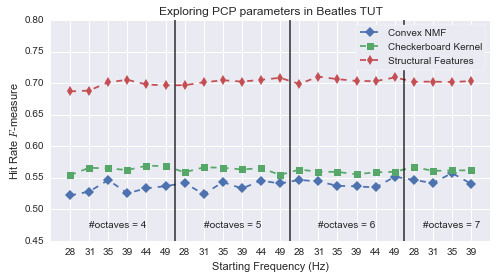

In [118]:
# Plot bound scores
sns.set_style("darkgrid", {'legend.frameon': True})
plt.figure(figsize=(7, 4))
algo_scores = {}
params = []
for n_octave in n_octaves:
    for f_min in f_mins:
        key = "noctavesE%d_fminE%.1f" % (n_octave, f_min)
        for i, bound_id in enumerate(bound_scores[key + boundsID_str]):
            if bound_id not in algo_scores.keys():
                algo_scores[bound_id] = []
            algo_scores[bound_id].append(bound_scores[key][i].mean())
        params.append(key)

marks = ["D", "s", "d"]
for i, bound_id in enumerate(algo_scores.keys()):
    plt.plot(algo_scores[bound_id], "--%s" % marks[i], label=algorithm_dict[bound_id])
n_params = len(params) - 2
x_offset = 1
plt.xticks(xrange(n_params))
plt.gca().set_xticklabels(4 * [ "%.0f" % f_min for f_min in f_mins])
plt.xlim((-x_offset, n_params - 1 + x_offset))
plt.xlabel("Starting Frequency (Hz)")
plt.ylim((0.45, .8))
plt.ylabel("Hit Rate $F$-measure")
plt.title("Exploring PCP parameters in Beatles TUT")
plt.legend()

# Add octave bars
for i in xrange(len(n_octaves)):
    plt.axvline((i + 1) * len(f_mins) - .5, color="k", alpha=0.7)
    x_off = 1
    if i == 3:
        x_off = 0.5
    plt.text((i) * len(f_mins) + x_off, 0.47, "#octaves = %d" % n_octaves[i])
plt.tight_layout()
plt.savefig("../figs/features_bounds.pdf")
plt.show()

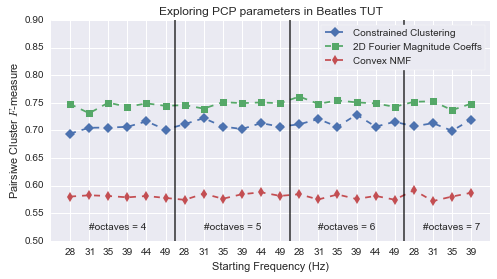

In [119]:
# Plot bound scores
sns.set_style("darkgrid", {'legend.frameon': True})
plt.figure(figsize=(7, 4))
algo_scores = {}
params = []
for n_octave in n_octaves:
    for f_min in f_mins:
        key = "noctavesE%d_fminE%.1f" % (n_octave, f_min)
        for i, bound_id in enumerate(label_scores[key + labelsID_str]):
            if bound_id not in algo_scores.keys():
                algo_scores[bound_id] = []
            algo_scores[bound_id].append(label_scores[key][i].mean())
        params.append(key)

marks = ["D", "s", "d"]
for i, label_id in enumerate(algo_scores.keys()):
    plt.plot(algo_scores[label_id], "--%s" % marks[i], label=algorithm_dict[label_id])
n_params = len(params) - 2
x_offset = 1
plt.xticks(xrange(n_params))
plt.gca().set_xticklabels(4 * [ "%.0f" % f_min for f_min in f_mins])
plt.xlim((-x_offset, n_params - 1 + x_offset))
plt.xlabel("Starting Frequency (Hz)")
plt.ylim((0.5, .9))
plt.ylabel("Pairsiwe Cluster $F$-measure")
plt.title("Exploring PCP parameters in Beatles TUT")
plt.legend(loc=1)

# Add octave bars
for i in xrange(len(n_octaves)):
    plt.axvline((i + 1) * len(f_mins) - .5, color="k", alpha=0.7)
    x_off = 1
    if i == 3:
        x_off = 0.5
    plt.text((i) * len(f_mins) + x_off, 0.52, "#octaves = %d" % n_octaves[i])
plt.tight_layout()
plt.savefig("../figs/features_labels.pdf")
plt.show()

In [176]:
def get_bound_dataframe(algo_id):
    octave_numbers = []
    min_frequencies = []
    scores = []
    for n_octave in n_octaves:
        for f_min in f_mins:
            if n_octave == 7 and f_min > 40:
                continue
            key = "noctavesE%d_fminE%.1f" % (n_octave, f_min)
            algo_name = bound_scores[key + boundsID_str][algo_id]
            for score in bound_scores[key][algo_id]:
                octave_numbers.append(n_octave)
                min_frequencies.append(f_min)
                scores.append(score)

    # To DataFrame
    d = { 
         "Octave"  : np.asarray(octave_numbers),
         "Frequency" : np.asarray(min_frequencies),
         "Score"      : np.asarray(scores)
        }
    df = pd.DataFrame(d)
    return df, algo_name

# PLOT
# plt.figure(figsize=(7,5))
# interaction_plot(df["Frequency"], df["Octave"],
#                  df["Score"], colors=['b', 'g', 'r'],
#                  markers=['D', '^', '*'], ms=9, ax=plt.gca(), legendloc="lower center")
# plt.gca().set_ylim([0.2, 0.8])
# plt.tight_layout()
# plt.savefig("control-ANOVA-F3.pdf")
# plt.show()

# Structural Features
df, algo_name = get_bound_dataframe(0)
sum_lm = ols("Score ~ C(Frequency, Sum) * C(Octave, Sum)", data=df).fit()
print algo_name, anova_lm(sum_lm, typ=2)

# Checkerboard Kernel
df, algo_name = get_bound_dataframe(1)
sum_lm = ols("Score ~ C(Frequency, Sum) * C(Octave, Sum)", data=df).fit()
print algo_name, anova_lm(sum_lm, typ=2)

# Convex NMF
df, algo_name = get_bound_dataframe(2)
sum_lm = ols("Score ~ C(Frequency, Sum) * C(Octave, Sum)", data=df).fit()
print algo_name, anova_lm(sum_lm, typ=2)

sf                                         sum_sq    df             F    PR(>F)
C(Frequency, Sum)                -4.497526e-12     5 -4.398765e-11  1.000000
C(Octave, Sum)                   -1.758293e-11     3 -2.866137e-10  1.000000
C(Frequency, Sum):C(Octave, Sum)  1.026273e+00    15  3.345791e+00  0.000012
Residual                          7.778815e+01  3804           NaN       NaN
foote                                         sum_sq    df             F  PR(>F)
C(Frequency, Sum)                 3.385908e-12     5  3.222169e-11       1
C(Octave, Sum)                   -2.358485e-12     3 -3.740718e-11       1
C(Frequency, Sum):C(Octave, Sum) -2.827272e-01    15 -8.968494e-01       1
Residual                          7.994612e+01  3804           NaN     NaN
cnmf                                         sum_sq    df             F  PR(>F)
C(Frequency, Sum)                 1.192380e-11     5  1.100489e-10       1
C(Octave, Sum)                    1.528315e-11     3  2.350892e-10       1
C

In [178]:
def get_label_dataframe(algo_id):
    octave_numbers = []
    min_frequencies = []
    scores = []
    for n_octave in n_octaves:
        for f_min in f_mins:
            if n_octave == 7 and f_min > 40:
                continue
            key = "noctavesE%d_fminE%.1f" % (n_octave, f_min)
            algo_name = label_scores[key + labelsID_str][algo_id]
            for score in label_scores[key][algo_id]:
                octave_numbers.append(n_octave)
                min_frequencies.append(f_min)
                scores.append(score)

    # To DataFrame
    d = { 
         "Octave"  : np.asarray(octave_numbers),
         "Frequency" : np.asarray(min_frequencies),
         "Score"      : np.asarray(scores)
        }
    df = pd.DataFrame(d)
    return df, algo_name

# PLOT
# plt.figure(figsize=(7,5))
# interaction_plot(df["Frequency"], df["Octave"],
#                  df["Score"], colors=['b', 'g', 'r'],
#                  markers=['D', '^', '*'], ms=9, ax=plt.gca(), legendloc="lower center")
# plt.gca().set_ylim([0.2, 0.8])
# plt.tight_layout()
# plt.savefig("control-ANOVA-F3.pdf")
# plt.show()

# Convex NMF
df, algo_name = get_label_dataframe(0)
sum_lm = ols("Score ~ C(Frequency, Sum) * C(Octave, Sum)", data=df).fit()
print algo_name, anova_lm(sum_lm, typ=2)

# 2D-FMC
df, algo_name = get_label_dataframe(1)
sum_lm = ols("Score ~ C(Frequency, Sum) * C(Octave, Sum)", data=df).fit()
print algo_name, anova_lm(sum_lm, typ=2)

# Constrained Cluster
df, algo_name = get_label_dataframe(2)
sum_lm = ols("Score ~ C(Frequency, Sum) * C(Octave, Sum)", data=df).fit()
print algo_name, anova_lm(sum_lm, typ=2)

cnmf                                         sum_sq    df             F  PR(>F)
C(Frequency, Sum)                 5.539392e-12     5  7.919513e-11       1
C(Octave, Sum)                    8.043887e-12     3  1.916686e-10       1
C(Frequency, Sum):C(Octave, Sum) -3.151533e+00    15 -1.501886e+01       1
Residual                          5.321501e+01  3804           NaN     NaN
fmc2d                                         sum_sq    df             F  PR(>F)
C(Frequency, Sum)                -7.125381e-12     5 -8.144284e-11       1
C(Octave, Sum)                    1.026710e-11     3  1.955876e-10       1
C(Frequency, Sum):C(Octave, Sum) -6.316905e-02    15 -2.406733e-01       1
Residual                          6.656189e+01  3804           NaN     NaN
cc                                         sum_sq    df             F    PR(>F)
C(Frequency, Sum)                -6.988139e-12     5 -6.752848e-11  1.000000
C(Octave, Sum)                   -7.796545e-11     3 -1.255672e-09  1.000000
C(Fre

['Checkerboard Kernel' 'Constrained Clustering' 'Convex NMF'
 'Laplacian Segmentation' 'Shift-Invariant PLCA' 'Structural Features']


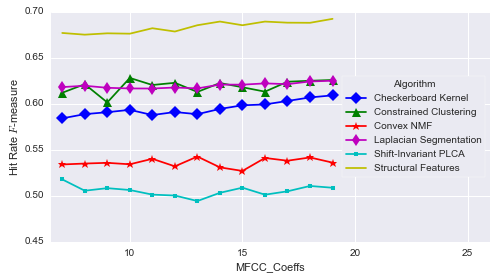

                                           sum_sq     df           F    PR(>F)
C(Algorithm, Sum)                       46.251670      5  463.931255  0.000000
C(MFCC_Coeffs, Sum)                      0.155026     12    0.647918  0.802407
C(Algorithm, Sum):C(MFCC_Coeffs, Sum)    0.291849     60    0.243951  1.000000
Residual                               269.057122  13494         NaN       NaN


In [133]:
# MFCC coeffs
results_mfcc_dirs = glob.glob(os.path.join(data_path, "results_mfcc_coeffE*"))

# ANOVA on Boundaries
algo_ids = []
coeffs = []
scores = []
for mfcc_dir in results_mfcc_dirs:
    coeff = int(os.path.basename(mfcc_dir).split('E')[-1])
    results_mfcc = glob.glob(os.path.join(mfcc_dir, "*.csv"))
    for curr_file in results_mfcc:
        algo_id, feature, annotator = get_result_attributes(curr_file, "bounds")
        if algo_id == "olda":
            continue
        if "labelsENone" in curr_file:
            results = pd.read_csv(curr_file)
            for result in results[bound_metric]:
                scores.append(result)
                coeffs.append(coeff)
                algo_ids.append(algorithm_dict[algo_id])

# To DataFrame
d = { 
     "Algorithm"  : np.asarray(algo_ids),
     "MFCC_Coeffs" : np.asarray(coeffs),
     "Score"      : np.asarray(scores)
    }
df = pd.DataFrame(d)

print np.unique(df["Algorithm"])

# PLOT
plt.figure(figsize=(7,4))
interaction_plot(df["MFCC_Coeffs"], df["Algorithm"],
                 df["Score"], colors=['b', 'g', 'r', 'm', 'c', 'y'],
                 markers=['D', '^', '*', 'd', '.', '_'], ms=9, ax=plt.gca(), legendloc="center right")
plt.gca().set_ylim([.45, .7])
plt.gca().set_xlim([6.5, 26.])
plt.ylabel("Hit Rate $F$-measure")
plt.tight_layout()
plt.savefig("../figs/features_bounds_mfcc_anova.pdf")
plt.show()

sum_lm = ols("Score ~ C(Algorithm, Sum) * C(MFCC_Coeffs, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

['2D Fourier Magnitude Coeffs' 'Constrained Clustering' 'Convex NMF'
 'Laplacian Segmentation' 'Shift-Invariant PLCA']


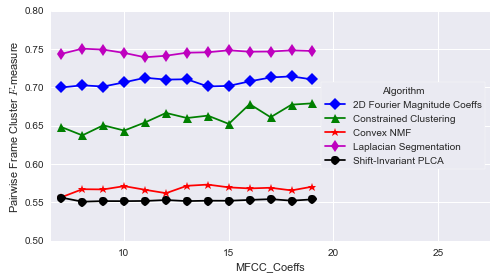

                                           sum_sq     df           F    PR(>F)
C(Algorithm, Sum)                       64.999249      4  917.362183  0.000000
C(MFCC_Coeffs, Sum)                      0.138432     12    0.651248  0.799359
C(Algorithm, Sum):C(MFCC_Coeffs, Sum)    0.355841     48    0.418511  0.999870
Residual                               199.189744  11245         NaN       NaN


In [98]:
# MFCC ANOVA on Labels
algo_ids = []
coeffs = []
scores = []
for mfcc_dir in results_mfcc_dirs:
    coeff = int(os.path.basename(mfcc_dir).split('E')[-1])
    results_mfcc = glob.glob(os.path.join(mfcc_dir, "*.csv"))
    for curr_file in results_mfcc:
        algo_id, feature, annotator = get_result_attributes(curr_file, "labels")
        if algo_id == "olda":
            continue
        if "boundsEgt" in curr_file:
            results = pd.read_csv(curr_file)
            for result in results[label_metric]:
                scores.append(result)
                coeffs.append(coeff)
                algo_ids.append(algorithm_dict[algo_id])

# To DataFrame
d = { 
     "Algorithm"  : np.asarray(algo_ids),
     "MFCC_Coeffs" : np.asarray(coeffs),
     "Score"      : np.asarray(scores)
    }
df = pd.DataFrame(d)

print np.unique(df["Algorithm"])

# PLOT
plt.figure(figsize=(7,4))
interaction_plot(df["MFCC_Coeffs"], df["Algorithm"],
                 df["Score"], colors=['b', 'g', 'r', 'm', 'k'],
                 markers=['D', '^', '*', 'd', 'o'], ms=9, ax=plt.gca(), legendloc="center right")
plt.gca().set_ylim([.5, .8])
plt.gca().set_xlim([6.5, 27.5])
plt.ylabel("Pairwise Frame Cluster $F$-measure")
plt.tight_layout()
plt.savefig("../figs/features_labels_mfcc_anova.pdf")
plt.show()

sum_lm = ols("Score ~ C(Algorithm, Sum) * C(MFCC_Coeffs, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

### Feature Types ###

* PCP
* MFCC
* Tonnetz
* CQT


In [298]:
results_features_path = "results_feature_types"
results_features_files = glob.glob(os.path.join(data_path, results_features_path, "*.csv"))
bound_metric = "HitRate_3F"
label_metric = "PWF"
xticks = ["CQT", "PCP", "MFCC", "Tonnetz"]

def get_result_attributes(result_file, algo_type="bounds"):
    algo_id = None
    feature = None
    annotator = None
    for param in os.path.basename(result_file)[:-4].split("_"):
        if algo_type in param and algo_id is None:
            algo_id = param.split("E")[1]
        if "feature" in param:
            feature = param.split("E")[1]
        if "annotator" in param:
            annotator = param.split("E")[1]
    return algo_id, feature, annotator

['Checkerboard Kernel' 'Constrained Clustering' 'Convex NMF'
 'Shift-Invariant PLCA' 'Structural Features']


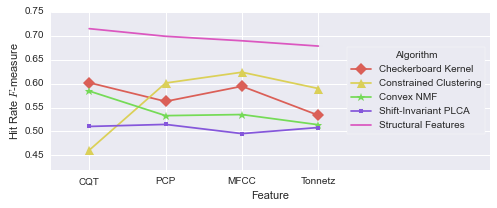

                                      sum_sq    df           F         PR(>F)
C(Algorithm, Sum)                  14.034620     4  172.688827  5.040358e-135
C(Feature, Sum)                     0.255801     3    4.196662   5.667868e-03
C(Algorithm, Sum):C(Feature, Sum)   3.693566    12   15.149146   1.436419e-31
Residual                           70.299547  3460         NaN            NaN
Friedman test
Test statistic: 76.14
Class rank sums: 2349.5 2319.5 2079.5 1951.5
p-value for  3 degree of freedom: 2.06419691013e-16
class ranks
  1 2349.5
  2 2319.5
  3 2079.5
  4 1951.5
(93.521830985915187, 3.8367233500401711e-20)


In [300]:
# ANOVA on Boundaries
algo_ids = []
features = []
scores = []
G = []
for curr_file in results_features_files:
    algo_id, feature, annotator = get_result_attributes(curr_file, "bounds")
    if algo_id == "olda" or algo_id == "scluster":
        continue
    if "labelsENone" in curr_file:
        results = pd.read_csv(curr_file)
        G.append(results[bound_metric])
        for result in results[bound_metric]:
            scores.append(result)
            features.append(feature)
            algo_ids.append(algorithm_dict[algo_id])

# To DataFrame
d = { 
     "Algorithm"  : np.asarray(algo_ids),
     "Feature" : np.asarray(features),
     "Score"      : np.asarray(scores)
    }
df = pd.DataFrame(d)

print np.unique(df["Algorithm"])
N = len(np.unique(df["Algorithm"]))

# PLOT
plt.figure(figsize=(7,3))
interaction_plot(df["Feature"], df["Algorithm"],
                 df["Score"], colors=colors_bounds[:3] + colors_bounds[5:7],
                 markers=markers[:3] + markers[5:7], ms=9, ax=plt.gca(), legendloc="center right")
# interaction_plot(df["Feature"], df["Algorithm"],
#                  df["Score"], colors=colors_bounds[:7],
#                  markers=markers[:7], ms=9, ax=plt.gca(), legendloc="center right")
plt.gca().set_ylim([0.42, 0.75])
plt.gca().set_xlim([-0.5, 5.25])
plt.ylabel("Hit Rate $F$-measure")
plt.gca().set_xticklabels(xticks)
plt.tight_layout()
plt.savefig("../figs/features_bounds_anova.pdf")
plt.show()

sum_lm = ols("Score ~ C(Algorithm, Sum) * C(Feature, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)


G = np.asarray(G).reshape((len(np.unique(df["Feature"])), 174 * len(np.unique(df["Algorithm"])))) 
# G = np.asarray(G).reshape((len(np.unique(df["Algorithm"])), len(np.unique(df["Feature"]))))
friedman(G, alpha = 0.05, ignoreties = False, onetailed = True, verbose = True)
print friedmanchisquare(*G)

['2D Fourier Magnitude Coeffs' 'Constrained Clustering' 'Convex NMF'
 'Shift-Invariant PLCA']


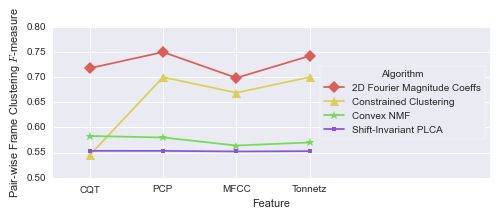

                                      sum_sq    df           F         PR(>F)
C(Algorithm, Sum)                  13.183204     3  255.209239  3.250052e-146
C(Feature, Sum)                     0.933705     3   18.075279   1.293014e-11
C(Algorithm, Sum):C(Feature, Sum)   2.247777     9   14.504652   3.492655e-23
Residual                           47.661685  2768         NaN            NaN
Friedman test
Test statistic: 285.300431034
Class rank sums: 2154.0 1670.0 1349.5 1786.5
p-value for  3 degree of freedom: 1.50974689818e-61
class ranks
  1 2154.0
  2 1670.0
  3 1349.5
  4 1786.5
(354.18215102974773, 1.853947984140241e-76)


In [283]:
# ANOVA on Labels
algo_ids = []
features = []
scores = []
G = []
for curr_file in results_features_files:
    algo_id, feature, annotator = get_result_attributes(curr_file, "labelsE")
    if algo_id == "olda" or algo_id == "scluster":
        continue
    if "boundsEgt" in curr_file:
        results = pd.read_csv(curr_file)
        G.append(results[label_metric])
        for result in results[label_metric]:
            scores.append(result)
            features.append(feature)
            algo_ids.append(algorithm_dict[algo_id])

# To DataFrame
d = { 
     "Algorithm"  : np.asarray(algo_ids),
     "Feature" : np.asarray(features),
     "Score"      : np.asarray(scores)
    }
df = pd.DataFrame(d)

print np.unique(df["Algorithm"])
N = len(np.unique(df["Algorithm"]))

# PLOT
plt.figure(figsize=(7,3))
interaction_plot(df["Feature"], df["Algorithm"],
                 df["Score"], colors=colors_bounds[:3] + [colors_bounds[5]],
                 markers=markers_labels[:3] + [markers_labels[4]], ms=9, ax=plt.gca(), legendloc="center right")
plt.gca().set_ylim([0.5, 0.8])
plt.gca().set_xlim([-0.5, 5.45])
plt.gca().set_xticklabels(xticks)
plt.ylabel("Pair-wise Frame Clustering $F$-measure")
plt.tight_layout()
plt.savefig("../figs/features_labels_anova.pdf")
plt.show()

sum_lm = ols("Score ~ C(Algorithm, Sum) * C(Feature, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

G = np.asarray(G).reshape((len(np.unique(df["Feature"])), 174 * len(np.unique(df["Algorithm"])))) 
# G = np.asarray(G).reshape((len(np.unique(df["Algorithm"])), len(np.unique(df["Feature"]))))
friedman(G, alpha = 0.05, ignoreties = False, onetailed = True, verbose = True)
print friedmanchisquare(*G)

In [136]:
import numpy as np
import scipy.special as special

def FPvalue( *args):
    """ Return F an p value

    """
    df_btwn, df_within = __degree_of_freedom_( *args)

    mss_btwn = __ss_between_( *args) / float( df_btwn)   
    mss_within = __ss_within_( *args) / float( df_within)

    F = mss_btwn / mss_within    
    P = special.fdtrc( df_btwn, df_within, F)

    return( F, P)

def EffectSize( *args):
    """ Return the eta squared as the effect size for ANOVA

    """    
    return( float( __ss_between_( *args) / __ss_total_( *args)))

def __concentrate_( *args):
    """ Concentrate input list-like arrays

    """
    v = list( map( np.asarray, args))
    vec = np.hstack( np.concatenate( v))
    return( vec)

def __ss_total_( *args):
    """ Return total of sum of square

    """
    vec = __concentrate_( *args)
    ss_total = sum( (vec - np.mean( vec)) **2)
    return( ss_total)

def __ss_between_( *args):
    """ Return between-subject sum of squares

    """    
    # grand mean
    grand_mean = np.mean( __concentrate_( *args))

    ss_btwn = 0
    for a in args:
        ss_btwn += ( len(a) * ( np.mean( a) - grand_mean) **2)

    return( ss_btwn)

def __ss_within_( *args):
    """Return within-subject sum of squares

    """
    return( __ss_total_( *args) - __ss_between_( *args))

def __degree_of_freedom_( *args):
    """Return degree of freedom

       Output-
              Between-subject dof, within-subject dof
    """   
    args = list( map( np.asarray, args))
    # number of groups minus 1
    df_btwn = len( args) - 1

    # total number of samples minus number of groups
    df_within = len( __concentrate_( *args)) - df_btwn - 1

    return( df_btwn, df_within)

In [144]:
from scipy import stats

bound_experiments = []
for key in bound_scores.keys():
    if boundsID_str not in key:
        print key
        if "noctavesE7" in key:
            bound_experiments.append(np.array(bound_scores[key][0]))

print FPvalue(*bound_experiments)
print __degree_of_freedom_(*bound_experiments)

noctavesE6_fminE27.5
noctavesE5_fminE27.5
noctavesE7_fminE38.9
noctavesE6_fminE30.9
noctavesE6_fminE49.0
noctavesE4_fminE30.9
noctavesE7_fminE30.9
noctavesE5_fminE43.7
noctavesE5_fminE34.6
noctavesE6_fminE43.7
noctavesE6_fminE34.6
noctavesE4_fminE43.7
noctavesE5_fminE38.9
noctavesE4_fminE49.0
noctavesE5_fminE49.0
noctavesE4_fminE27.5
noctavesE5_fminE30.9
noctavesE4_fminE34.6
noctavesE7_fminE34.6
noctavesE6_fminE38.9
noctavesE7_fminE27.5
noctavesE4_fminE38.9
(0.0038348887466734404, 0.99967258756596578)
(3, 692)


In [131]:
stats.f_oneway(*bound_experiments)

(0.29005887152702348, 0.99934582933063154)

# Algorithms #

Running label algorithms on all the different boundaries results on The Beatles TUT dataset.

In [292]:
results_algorithms_path = "results_algorithms"
results_algorithms_files = glob.glob(os.path.join(data_path, results_algorithms_path, "*.csv"))
xticks = ["Human", "SF", "Laplacian", "CC", "OLDA", "Checkerboard", "C-NMF", "SI-PLCA"]

fmc2d
cnmf
siplca
cc
scluster
['2D Fourier Magnitude Coeffs' 'Constrained Clustering' 'Convex NMF'
 'Laplacian Segmentation' 'Shift-Invariant PLCA']


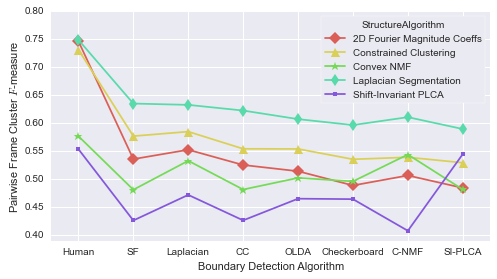

                                                         sum_sq    df  \
C(StructureAlgorithm, Sum)                            20.750283     4   
C(BoundaryAlgorithm, Sum)                             16.308552     7   
C(StructureAlgorithm, Sum):C(BoundaryAlgorithm, Sum)   5.857881    28   
Residual                                              88.049481  6920   

                                                               F  \
C(StructureAlgorithm, Sum)                            407.702452   
C(BoundaryAlgorithm, Sum)                             183.103501   
C(StructureAlgorithm, Sum):C(BoundaryAlgorithm, Sum)   16.442272   
Residual                                                     NaN   

                                                             PR(>F)  
C(StructureAlgorithm, Sum)                            6.952535e-316  
C(BoundaryAlgorithm, Sum)                             9.295104e-250  
C(StructureAlgorithm, Sum):C(BoundaryAlgorithm, Sum)   6.305737e-77  
Residual     

225.05287356321833

In [297]:
# ANOVA of the combination of algorithms for labels
bound_ids = []
label_ids = []
scores = []
G = []
for curr_file in results_algorithms_files:
    bound_id, feature, annotator = get_result_attributes(curr_file, "bounds")
    label_id, feature, annotator = get_result_attributes(curr_file, "labels")
    results = pd.read_csv(curr_file)
#     if label_id == "cnmf" or label_id == "siplca":# or bound_id == "gt":
#         continue
#     print results
#     print label_id
    if bound_id == "gt":
        bound_id = "a_gt"
    if bound_id == "sf":
        bound_id = "b_sf"
    if bound_id == "scluster":
        bound_id = "c_laplacian"
    if bound_id == "cc":
        bound_id = "d_cc"
    if bound_id == "olda":
        bound_id = "e_olda"
    if bound_id == "foote":
        bound_id = "f_foote"
    if bound_id == "cnmf":
        bound_id = "g_cnmf"
        print label_id
        G.append(results[label_metric])
    if bound_id == "siplca":
        bound_id = "h_siplca"
    for result in results[label_metric]:
        scores.append(result)
        bound_ids.append(bound_id)
        label_ids.append(algorithm_dict[label_id])

# To DataFrame
d = { 
     "StructureAlgorithm"  : np.asarray(label_ids),
     "BoundaryAlgorithm" : np.asarray(bound_ids),
     "Score"      : np.asarray(scores)
    }
df = pd.DataFrame(d)

print np.unique(df["StructureAlgorithm"])
N = len(np.unique(df["StructureAlgorithm"]))

# PLOT
plt.figure(figsize=(7,4))
interaction_plot(df["BoundaryAlgorithm"], df["StructureAlgorithm"],
                 df["Score"], colors=colors_bounds[:4] + [colors_bounds[5]],
                 markers=markers_labels[:N], ms=9, ax=plt.gca(), legendloc="upper right")
plt.gca().set_ylim([0.39, 0.8])
plt.gca().set_xlim([-0.5, 7.5])
plt.gca().set_xticklabels(xticks)
plt.xlabel("Boundary Detection Algorithm")
plt.ylabel("Pairwise Frame Cluster $F$-measure")
plt.tight_layout()
plt.savefig("../figs/algorithms_anova.pdf")
plt.show()

sum_lm = ols("Score ~ C(StructureAlgorithm, Sum) * C(BoundaryAlgorithm, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

# G = np.asarray(G).reshape((len(np.unique(df["BoundaryAlgorithm"])), 174 * len(np.unique(df["LabelAlgorithm"])))) 
# G = np.asarray(G).reshape((len(np.unique(df["BoundaryAlgorithm"])), len(np.unique(df["LabelAlgorithm"]))))
# print G.T
# friedman(G, alpha = 0.05, ignoreties = False, onetailed = True, verbose = True)
# K = []
# off = 5
# for i in xrange(0 + off, 5 + off):
#     K.append(G[i])
#     print np.mean(G[i])
friedman(G, alpha = 0.05, ignoreties = False, onetailed = True, verbose = True)    

# Datasets

Check for the variation in algorithms depending on the dataset. It would be interesting to show that some algorithms perform better than others depending on the dataset.

In [411]:
results_datasets_path = "results_datasets"
results_datasets_files = glob.glob(os.path.join(data_path, results_datasets_path, "*.csv"))
bound_metric = "HitRate_3F"
xticks = ["Beatles", "Cerulean", "Epiphyte", "Isophonics", "SALAMI", "Sargon", "SPAM"]

['Checkerboard Kernel' 'Constrained Clustering' 'Convex NMF'
 'Laplacian Segmentation' 'Ordinal LDA' 'Shift-Invariant PLCA'
 'Structural Features']


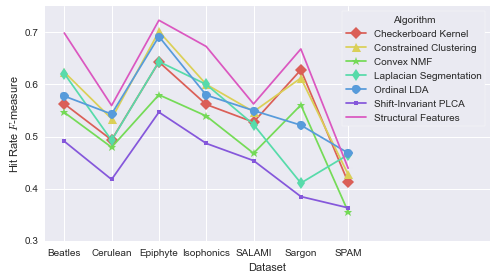

                                       sum_sq     df           F        PR(>F)
C(Algorithm, Sum)                   42.071109      6  333.578383  0.000000e+00
C(Dataset, Sum)                     64.722268      6  513.177570  0.000000e+00
C(Algorithm, Sum):C(Dataset, Sum)    4.203679     36    5.555105  1.910309e-24
Residual                           349.459189  16625         NaN           NaN
Friedman test
Test statistic: 5.51020408163
Class rank sums: 21 34 24 22 31 31 33
p-value for  6 degree of freedom: 0.480224261607
class ranks
  1   21.0
  2   34.0
  3   24.0
  4   22.0
  5   31.0
  6   31.0
  7   33.0
(5.5102040816326507, 0.48022426160692588)


In [412]:
# ANOVA on Boundaries
algo_ids = []
ds_names = []
scores = []
G = []
for curr_file in results_datasets_files:
    if "labelsENone" in curr_file:
        algo_id, feature, annotator = get_result_attributes(curr_file, "bounds")
        ds_name = os.path.basename(curr_file).split("_")[1]
        if ds_name == "BeatlesTUT":
            ds_name = "Beatles"
        if ds_name == "SPAM":
            ds_name = "spam"
        results = pd.read_csv(curr_file)
        G.append(results[bound_metric].mean())
        for result in results[bound_metric]:
            scores.append(result)
            ds_names.append(ds_name)
            algo_ids.append(algorithm_dict[algo_id])

# To DataFrame
d = { 
     "Algorithm"  : np.asarray(algo_ids),
     "Dataset" : np.asarray(ds_names),
     "Score"      : np.asarray(scores)
    }
df = pd.DataFrame(d)

print np.unique(df["Algorithm"])
N = len(np.unique(df["Algorithm"]))

# PLOT
plt.figure(figsize=(7,4))
interaction_plot(df["Dataset"], df["Algorithm"],
                 df["Score"], colors=colors_bounds[:N],
                 markers=markers[:N], ms=9, ax=plt.gca(), legendloc="upper right")
plt.gca().set_ylim([0.3, .75])
plt.gca().set_xlim([-0.4, 9])
plt.gca().set_xticklabels(xticks)
plt.ylabel("Hit Rate $F$-measure")
plt.tight_layout()
plt.savefig("../figs/datasets_bounds_anova.pdf")
plt.show()

sum_lm = ols("Score ~ C(Algorithm, Sum) * C(Dataset, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

G = np.asarray(G).reshape((len(np.unique(df["Algorithm"])), len(np.unique(df["Dataset"]))))
# G = np.asarray(G).reshape((len(np.unique(df["Feature"])), 174 * len(np.unique(df["Algorithm"]))))
friedman(G, alpha = 0.05, ignoreties = False, onetailed = True, verbose = True)
print friedmanchisquare(*G)

['2D Fourier Magnitude Coeffs' 'Constrained Clustering' 'Convex NMF'
 'Laplacian Segmentation' 'Shift-Invariant PLCA']


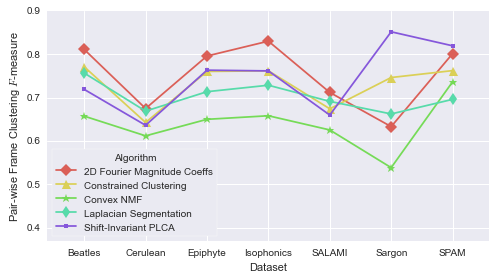

                                       sum_sq     df           F  \
C(Algorithm, Sum)                   19.814548      4  274.812110   
C(Dataset, Sum)                     14.401993      6  133.162840   
C(Algorithm, Sum):C(Dataset, Sum)    4.205640     24    9.721483   
Residual                           214.053298  11875         NaN   

                                          PR(>F)  
C(Algorithm, Sum)                  2.593986e-226  
C(Dataset, Sum)                    8.699285e-164  
C(Algorithm, Sum):C(Dataset, Sum)   8.256655e-36  
Residual                                     NaN  
Friedman test
Test statistic: 6.62857142857
Class rank sums: 24 21 14 28 18
p-value for  4 degree of freedom: 0.156867474908
class ranks
  1   24.0
  2   21.0
  3   14.0
  4   28.0
  5   18.0
(6.6285714285714334, 0.15686747490805691)


In [407]:
# ANOVA on Labels
algo_ids = []
ds_names = []
scores = []
G = []
for curr_file in results_datasets_files:
    if "boundsEgt" in curr_file:
        algo_id, feature, annotator = get_result_attributes(curr_file, "labels")
        ds_name = os.path.basename(curr_file).split("_")[1]
        results = pd.read_csv(curr_file)
        G.append(results[label_metric].mean())
        if ds_name == "SPAM":
            ds_name = "spam"
        for result in results[label_metric]:
            scores.append(result)
            ds_names.append(ds_name)
            algo_ids.append(algorithm_dict[algo_id])

# To DataFrame
d = { 
     "Algorithm"  : np.asarray(algo_ids),
     "Dataset" : np.asarray(ds_names),
     "Score"      : np.asarray(scores)
    }
df = pd.DataFrame(d)

print np.unique(df["Algorithm"])

N = len(np.unique(df["Algorithm"]))

# PLOT
plt.figure(figsize=(7,4))
interaction_plot(df["Dataset"], df["Algorithm"],
                 df["Score"], colors=colors_bounds[:4] + [colors_bounds[5]],
                 markers=markers_labels[:N], ms=9, ax=plt.gca(), legendloc="lower left")
plt.gca().set_ylim([0.37, .9])
plt.ylabel("Pair-wise Frame Clustering $F$-measure")
plt.gca().set_xticklabels(xticks)
plt.tight_layout()
plt.savefig("../figs/datasets_labels_anova.pdf")
plt.show()

sum_lm = ols("Score ~ C(Algorithm, Sum) * C(Dataset, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

G = np.asarray(G).reshape((len(np.unique(df["Algorithm"])), len(np.unique(df["Dataset"]))))
friedman(G, alpha = 0.05, ignoreties = False, onetailed = True, verbose = True)
print friedmanchisquare(*G)

# Annotations

Check how much the algorithm's scores change depending on the annotator.

6 different annotators in the Cerulean Dataset.

In [413]:
results_annotations_path = "results_annotations"
results_annotations_files = glob.glob(os.path.join(data_path, results_annotations_path, "*.csv"))

scluster
foote
cc
olda
siplca
cnmf
['Checkerboard Kernel' 'Constrained Clustering' 'Convex NMF'
 'Laplacian Segmentation' 'Ordinal LDA' 'Shift-Invariant PLCA'
 'Structural Features']
6


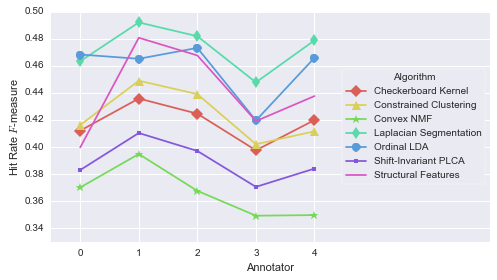

                                        sum_sq    df          F        PR(>F)
C(Algorithm, Sum)                     2.119406     6  13.065266  1.687590e-14
C(Annotator, Sum)                     0.438317     4   4.053071  2.830462e-03
C(Algorithm, Sum):C(Annotator, Sum)   0.158675    24   0.244541  9.999393e-01
Residual                             46.096615  1705        NaN           NaN
Friedman test
Test statistic: 28.2142857143
Class rank sums: 195.0 176.0 187.0 215.0 146.5 130.5
p-value for  5 degree of freedom: 3.30507879384e-05
class ranks
  1  195.0
  2  176.0
  3  187.0
  4  215.0
  5  146.5
  6  130.5


28.21428571428578

In [423]:
# ANOVA on Boundaries
algo_ids = []
annotators = []
scores = []
G = []
bound_metric = "HitRate_3F"
for curr_file in results_annotations_files:
    if "labelsENone" in curr_file:
        algo_id, feature, annotator = get_result_attributes(curr_file, "bounds")
        results = pd.read_csv(curr_file)
        if annotator == "0":
            if len(results[bound_metric]) == 50:
                print algo_id
                G.append(results[bound_metric])
#         print len(results[bound_metric]), algo_id, feature, annotator
        for result in results[bound_metric]:
            scores.append(result)
            annotators.append(annotator)
            algo_ids.append(algorithm_dict[algo_id])

# To DataFrame
d = { 
     "Algorithm"  : np.asarray(algo_ids),
     "Annotator" : np.asarray(annotators),
     "Score"      : np.asarray(scores)
    }
df = pd.DataFrame(d)

print np.unique(d["Algorithm"])
N = len(np.unique(d["Algorithm"]))
print len(G)

# PLOT
plt.figure(figsize=(7,4))
interaction_plot(df["Annotator"], df["Algorithm"],
                 df["Score"], colors=colors_bounds[:N],
                 markers=markers[:N], ms=9, ax=plt.gca(), legendloc="center right")
plt.gca().set_ylim([0.33, 0.5])
plt.gca().set_xlim([-0.5, 7])
plt.ylabel("Hit Rate $F$-measure")
plt.tight_layout()
plt.savefig("../figs/annotators_bounds_anova.pdf")
plt.show()

sum_lm = ols("Score ~ C(Algorithm, Sum) * C(Annotator, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

# G = np.asarray(G).reshape((len(np.unique(df["Algorithm"])), len(np.unique(df["Annotator"]))))
friedman(G, alpha = 0.05, ignoreties = False, onetailed = True, verbose = True)

['2D Fourier Magnitude Coeffs' 'Constrained Clustering' 'Convex NMF'
 'Laplacian Segmentation' 'Shift-Invariant PLCA']


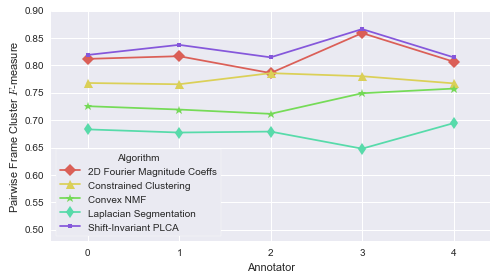

                                        sum_sq    df          F        PR(>F)
C(Algorithm, Sum)                     3.960361     4  48.298942  9.364459e-38
C(Annotator, Sum)                     0.088493     4   1.079223  3.653229e-01
C(Algorithm, Sum):C(Annotator, Sum)   0.306469    16   0.934391  5.287079e-01
Residual                             25.111536  1225        NaN           NaN


In [387]:
# ANOVA on Labels
algo_ids = []
annotators = []
scores = []
for curr_file in results_annotations_files:
    if "boundsEgt" in curr_file:
        algo_id, feature, annotator = get_result_attributes(curr_file, "labels")
        results = pd.read_csv(curr_file)
        for result in results[label_metric]:
            scores.append(result)
            annotators.append(annotator)
            algo_ids.append(algorithm_dict[algo_id])

# To DataFrame
d = { 
     "Algorithm"  : np.asarray(algo_ids),
     "Annotator" : np.asarray(annotators),
     "Score"      : np.asarray(scores)
    }
df = pd.DataFrame(d)

print np.unique(d["Algorithm"])
N = len(np.unique(d["Algorithm"]))

# PLOT
plt.figure(figsize=(7,4))
interaction_plot(df["Annotator"], df["Algorithm"],
                 df["Score"], colors=colors_bounds[:4] + [colors_bounds[5]],
                 markers=markers_labels[:N], ms=9, ax=plt.gca(), legendloc="lower left")
plt.gca().set_ylim([0.48, .9])
plt.ylabel("Pairwise Frame Cluster $F$-measure")
plt.tight_layout()
plt.savefig("../figs/annotators_labels_anova.pdf")
plt.show()

sum_lm = ols("Score ~ C(Algorithm, Sum) * C(Annotator, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

# Evaluation Metrics #

See differences in algorithm ranking depending on the evaluation metric:

Boundaries:
* Hit Rate 3-sec
* Hit Rate 0.5-sec
* Hit Rate 3-sec Trimmed
* Hit Rate 0.5-sec Trimmed
* Hit Rate 3-sec (weighted)
* Hit Rate 0.5-sec (weighted)
* Standard Deviations

Structural Grouping
* Pairwise Frame Clustering
* Normalized Entropy Scores


In [302]:
results_datasets_path = "results_datasets"
results_datasets_files = glob.glob(os.path.join(data_path, results_datasets_path, "*.csv"))
bound_metrics = ["HitRate_3F", "HitRate_t3F", "HitRate_0.5F", "HitRate_t0.5F", "DevE2R", "DevR2E"]
# bound_metrics = ["HitRate_3F", "HitRate_t3F", "HitRate_0.5F", "HitRate_t0.5F"]
label_metrics = ["PWF", "Sf"]
import mir_eval

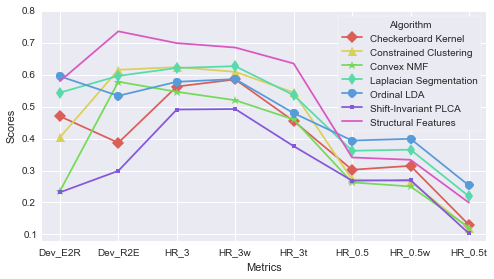

                                       sum_sq    df           F         PR(>F)
C(Algorithm, Sum)                   43.811074     6  118.025422  2.116668e-144
C(Metrics, Sum)                    198.563425     7  458.505051   0.000000e+00
C(Algorithm, Sum):C(Metrics, Sum)   29.197647    42   11.236770   4.482812e-72
Residual                           599.364782  9688         NaN            NaN
Friedman test
Test statistic: 210.677339901
Class rank sums: 713.5 938.5 569.0 794.5 490.0 536.0 830.5
p-value for  6 degree of freedom: 1.01015441485e-42
class ranks
  1  713.5
  2  938.5
  3  569.0
  4  794.5
  5  490.0
  6  536.0
  7  830.5


210.67733990147826

In [365]:
# ANOVA on Boundaries
algo_ids = []
metrics = []
scores = []
xticks = ["Dev_E2R", "Dev_R2E", "HR_3", "HR_3w", "HR_3t", "HR_0.5", "HR_0.5w", "HR_0.5t"]
G = []
for curr_file in results_datasets_files:
    if "labelsENone" in curr_file:
        algo_id, feature, annotator = get_result_attributes(curr_file, "bounds")
        ds_name = os.path.basename(curr_file).split("_")[1]
        if ds_name != "BeatlesTUT":
            continue
        results = pd.read_csv(curr_file)
        for bound_metric in bound_metrics:
            if bound_metric == "HitRate_0.5F":
                G.append(results[bound_metric])
            for result in results[bound_metric]:
                metric_name = bound_metric
                if bound_metric == "HitRate_3F":
                    metric_name = "E_HitRate_3F"
                if bound_metric == "HitRate_t3F":
                    metric_name = "E_HitRate_t3F"
                if bound_metric == "DevE2R" or bound_metric == "DevR2E":
                    result = 1 - result / 4.
                scores.append(result)
                metrics.append(metric_name)
                algo_ids.append(algorithm_dict[algo_id])
            if bound_metric == "HitRate_3F":
                metric_name = "E_HitRate_3Fw"
                for P, R in zip(results["HitRate_3P"], results["HitRate_3R"]):
                    scores.append(mir_eval.util.f_measure(P, R, beta=0.58))
                    metrics.append(metric_name)
                    algo_ids.append(algorithm_dict[algo_id])
            if bound_metric == "HitRate_0.5F":
                metric_name = "HitRate_0.5Fw"
                for P, R in zip(results["HitRate_0.5P"], results["HitRate_0.5R"]):
                    scores.append(mir_eval.util.f_measure(P, R, beta=0.58))
                    metrics.append(metric_name)
                    algo_ids.append(algorithm_dict[algo_id])
                    

# To DataFrame
d = { 
     "Algorithm"  : np.asarray(algo_ids),
     "Metrics" : np.asarray(metrics),
     "Score"      : np.asarray(scores)
    }
df = pd.DataFrame(d)

anova_len = len(np.unique(df["Algorithm"]))

# PLOT
plt.figure(figsize=(7,4))
interaction_plot(df["Metrics"], df["Algorithm"],
                 df["Score"], colors=colors_bounds[:anova_len],
                 markers=markers[:anova_len], ms=9, ax=plt.gca(), legendloc="upper right")
plt.gca().set_ylim([0.08, 0.8])
plt.gca().set_xlim([-0.3, 7.3])
plt.gca().set_xticklabels(xticks)
plt.ylabel("Scores")
plt.tight_layout()
plt.savefig("../figs/evaluation_bounds_anova.pdf")
plt.show()

sum_lm = ols("Score ~ C(Algorithm, Sum) * C(Metrics, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

friedman(G, alpha = 0.05, ignoreties = False, onetailed = True, verbose = True)

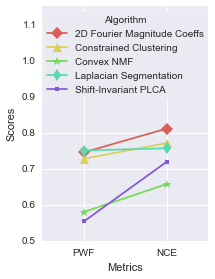

                                      sum_sq    df           F         PR(>F)
C(Algorithm, Sum)                   7.583083     4  134.490329  3.974582e-100
C(Metrics, Sum)                     2.235710     1  158.606404   7.338198e-35
C(Algorithm, Sum):C(Metrics, Sum)   1.208854     4   21.439714   2.794478e-17
Residual                           24.386017  1730         NaN            NaN
Friedman test
Test statistic: 230.105747126
Class rank sums: 658.5 623.5 359.5 629.0 339.5
p-value for  4 degree of freedom: 1.25264434686e-48
class ranks
  1  658.5
  2  623.5
  3  359.5
  4  629.0
  5  339.5


230.10574712643665

In [370]:
# ANOVA on Boundaries
algo_ids = []
metrics = []
scores = []
xticks = ["PWF", "NCE"]
G = []
for curr_file in results_datasets_files:
    if "boundsEgt" in curr_file:
        algo_id, feature, annotator = get_result_attributes(curr_file, "labels")
        ds_name = os.path.basename(curr_file).split("_")[1]
        if ds_name != "BeatlesTUT":
            continue
        results = pd.read_csv(curr_file)
        for label_metric in label_metrics:
            if label_metric == "PWF":
                G.append(results[label_metric])
            for result in results[label_metric]:
                scores.append(result)
                metrics.append(label_metric)
                algo_ids.append(algorithm_dict[algo_id])

# To DataFrame
d = { 
     "Algorithm"  : np.asarray(algo_ids),
     "Metrics" : np.asarray(metrics),
     "Score"      : np.asarray(scores)
    }
df = pd.DataFrame(d)

anova_len = len(np.unique(df["Algorithm"]))

# PLOT
plt.figure(figsize=(3.1,4))
interaction_plot(df["Metrics"], df["Algorithm"],
                 df["Score"], colors=colors_bounds[:4] + [colors_bounds[5]],
                 markers=markers_labels[:anova_len], ms=9, ax=plt.gca(), legendloc="upper center")
plt.gca().set_ylim([0.5, 1.15])
plt.gca().set_xlim([-0.5, 1.5])
plt.gca().set_xticklabels(xticks)
plt.ylabel("Scores")
plt.tight_layout()
plt.savefig("../figs/evaluation_labels_anova.pdf")
plt.show()

sum_lm = ols("Score ~ C(Algorithm, Sum) * C(Metrics, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

friedman(G, alpha = 0.05, ignoreties = False, onetailed = True, verbose = True)

In [197]:
# From: http://adorio-research.org/wordpress/?p=239

from scipy import stats
 
def isequalfloats(a, b, ztol = 1.0e-8):
    return True if  abs(a-b) < ztol else False
 
def friedman(G, alpha = 0.05, ignoreties = False, onetailed = True, verbose = True):
    """
    Performs Friedman's test.
     G -array of arrays(groups). First group is G[0]
        each group mus have the same number of elements!
 
    """
    nclasses = len(G)                      # number of groups
    nblocks  = len(G[0])
    Rank     = [0]* nclasses               # ranks array.
 
    for j in range(nblocks):
        # get the rows.
        row = []
        for i in range(nclasses):
            row.append((G[i][j], i))
        row.sort()
 
        start  = 0
        while start < nclasses:
           end = start
           for k in range(start+1, nclasses):
               if not isequalfloats(row[k-1][0], row[k][0]):
                  end = k-1
                  break
           if end > start:
              rank = (start + end)/2.0 + 1
           else:
              rank = start + 1
 
           for k in range(start, end+1):
               index = row[k][1]     
               Rank[index] += rank
           start = end + 1
 
    sumRankssqr = sum([rank * rank for rank in Rank])
 
    #Compute Friedman statistic.
    Friedman = 12.0/(nblocks * nclasses*(nclasses+1))*sumRankssqr-3*(nclasses +1) *nblocks
    df = nclasses -1
 
    if verbose:
       print "Friedman test"
       print "Test statistic:", Friedman
       print "Class rank sums:", 
       for rank in Rank: print rank,
       print
       print "p-value for ", nclasses-1, "degree of freedom:", stats.chi2.sf(Friedman, df)
       print "class ranks"
       for i, rank in enumerate(Rank):
           print "%3d %6.1f" %(i+1, rank)
    return Friedman
 
#Example from Berenson.
G = [
#     [70, 77, 76, 80, 84, 78],
#      [61, 75, 67,63,66, 68],
#      [82, 88,90, 96,92,98],
#      [74, 76, 80, 76, 84, 86],
    [74, 76, 80, 76, 84, 86],
    [84, 86, 90, 96, 94, 96]]


friedman(G, alpha = 0.05, ignoreties = False, onetailed = True, verbose = True)

Friedman test
Test statistic: 6.0
Class rank sums: 6 12
p-value for  1 degree of freedom: 0.0143058784354
class ranks
  1    6.0
  2   12.0


6.0